In [2]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import spectrogram_utilities
import output_utilities
import spectrogram_output_visualiser
import spectrogram_cuts_db_creation

import numpy as np
import pandas as pd
import h5py

import tensorflow as tf
import keras

from scipy import signal
from sklearn import preprocessing, metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# matplotlib.get_backend()
%matplotlib inline
#

In [3]:
# constants
awd_event = 1
site = parameters.sites[0]

## Database

### Loading H5 files

In [4]:
data = np.arange(parameters.clf_input_height*parameters.clf_input_width).reshape(1,parameters.clf_input_height*parameters.clf_input_width)
evt = np.arange(1)
# load dataset from every site
for site in parameters.sites:
    _data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'training_set_'+site+'.h5', verbose=True, noise=True)
    print(_data.shape, _evt.shape)
    data = np.append(data,_data, axis=0)
    evt = np.append(evt,_evt, axis=0)
# remove first element
data = np.delete(data, 0, 0)
evt = np.delete(evt, 0, 0)
# shuffle 
data = list(zip(data,evt))
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)
print(data.shape, evt.shape)


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 21.89 seconds
(19804, 16384) (19804,)

Loading spectrogram cuts from database for awdEvent1/sanae
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 2.59 seconds
(2289, 16384) (2289,)
(22093, 16384) (22093,)


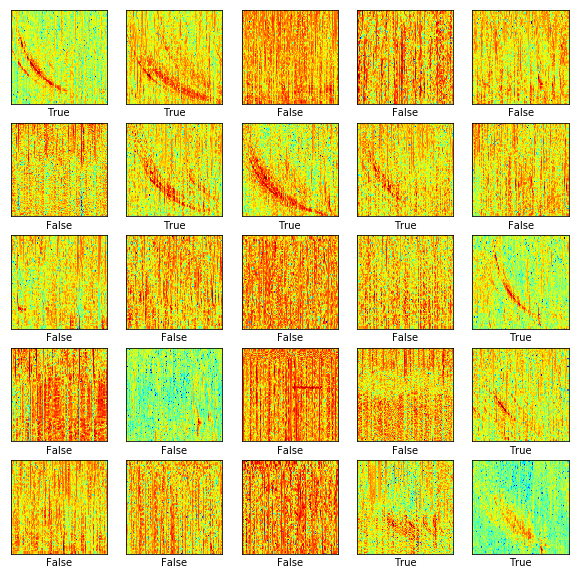

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k].reshape((parameters.clf_input_height,parameters.clf_input_width)), cmap='jet')
    plt.xlabel(np.bool_(evt[k]))
plt.show()

In [8]:
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

In [9]:
model = keras.Sequential([
#     keras.layers.Dense(1024, activation=tf.nn.relu),
#     keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
#     keras.layers.Dense(128, activation=tf.nn.relu),
#     keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dense(8, activation=tf.nn.relu),
#     keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# history = model.fit(data, evt, batch_size=int(len(data)/100), epochs=5, shuffle=True)

In [8]:
train_accuracies, train_losses = [], []
cv_accuracies , cv_losses = [], []
data_percent = 10
for data_slice in range(1,data_percent+1):
    print('\nData batch %s, size %d' %(data_slice,int(len(data)/data_percent)*data_slice))
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    _data = data[:int(len(data)/data_percent)*data_slice]
    _evt = evt[:int(len(data)/data_percent)*data_slice]
    # Random permutations cross-validation
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    # train and evaluate per cross-validation itteration
    train_loss, train_acc = 0, 0
    cv_loss, cv_acc = 0, 0
    i = 1
    for train_index, test_index in cv.split(_data,_evt):
        print('Fold %s/%s' % (i,int(cv.get_n_splits())))
        history = model.fit(_data[train_index], _evt[train_index], batch_size=int(len(_data[train_index])/100), epochs=5, shuffle=True, verbose=0)
        
        loss, acc = model.evaluate(_data[train_index], _evt[train_index], verbose=0)
        train_loss += loss 
        train_acc +=acc
        
        loss, acc = model.evaluate(_data[test_index], _evt[test_index], verbose=0)
        cv_loss += loss
        cv_acc += acc
        
        i+=1 

    train_loss /= int(cv.get_n_splits())
    train_acc  /= int(cv.get_n_splits())
    cv_loss    /= int(cv.get_n_splits())
    cv_acc     /= int(cv.get_n_splits())
    
    print('training loss: %s, training accuracy: %s' %(train_loss,train_acc))
    print('validation loss: %s, validation accuracy: %s' %(cv_loss,cv_acc))
    
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    cv_accuracies.append(cv_acc)
    cv_losses.append(cv_loss)
model.save('3_layers.h5')


Data batch 1, size 2209
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
training loss: 0.005751128336903959, training accuracy: 0.9996604414261461
validation loss: 0.05807261668208604, validation accuracy: 0.9855203617751869

Data batch 2, size 4418
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
training loss: 0.0009449816393138839, training accuracy: 0.9996038483305038
validation loss: 0.05503802169672395, validation accuracy: 0.9821266967786382

Data batch 3, size 6627
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
training loss: 0.0005108899393671809, training accuracy: 1.0
validation loss: 0.05388448951602772, validation accuracy: 0.9838612367484725

Data batch 4, size 8836
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
training loss: 0.0003651397729634865, training accuracy: 0.9999717034521789
validation loss: 0.043434077055669276, validation accuracy: 0.9881221719457013

Data batch 5, size 11045
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
training loss: 0.00036509345674443175, training 

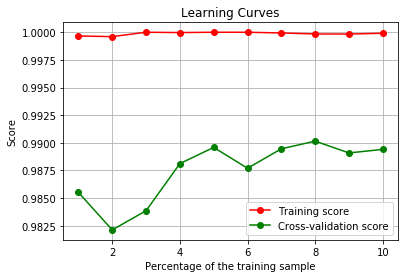

In [9]:
title= r"Learning Curves"
plt.figure()
plt.title(title)
plt.xlabel("Percentage of the training sample")
plt.ylabel("Score")

train_accuracies = np.array(train_accuracies)
cv_accuracies = np.array(cv_accuracies)

train_scores_mean = np.mean(train_accuracies)
train_scores_std = np.std(train_accuracies)
test_scores_mean = np.mean(cv_accuracies)
test_scores_std = np.std(cv_accuracies)
plt.grid()

train_sizes = range(int(len(data)/data_percent), len(data),int(len(data)/data_percent))
train_sizes = range(1, data_percent+1)
# plt.xticks(train_sizes)

# plt.fill_between(train_sizes,train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes,test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes,train_accuracies, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes,cv_accuracies, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [10]:
data = np.arange(parameters.clf_input_height*parameters.clf_input_width).reshape(1,parameters.clf_input_height*parameters.clf_input_width)
evt = np.arange(1)
# load dataset from every site
for site in parameters.sites:
    _data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'testing_set_'+site+'.h5', verbose=True, noise=True)
    print(_data.shape, _evt.shape)
    data = np.append(data,_data, axis=0)
    evt = np.append(evt,_evt, axis=0)
# remove first element
data = np.delete(data, 0, 0)
evt = np.delete(evt, 0, 0)
# shuffle 
data = list(zip(data,evt))
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)
print(data.shape, evt.shape)

predictions = model.predict(data)
pred = np.argmax(predictions, axis=1)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(evt, pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt, pred))


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 10.70 seconds
(9716, 16384) (9716,)

Loading spectrogram cuts from database for awdEvent1/sanae
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 1.44 seconds
(1245, 16384) (1245,)
(10961, 16384) (10961,)
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fe35c66e1d0>:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6248
           1       0.96      0.93      0.94      4713

   micro avg       0.95      0.95      0.95     10961
   macro avg       0.95      0.95      0.95     10961
weighted avg       0.95      0.95      0.95     10961


Confusion matrix:
[[6044  204]
 [ 320 4393]]


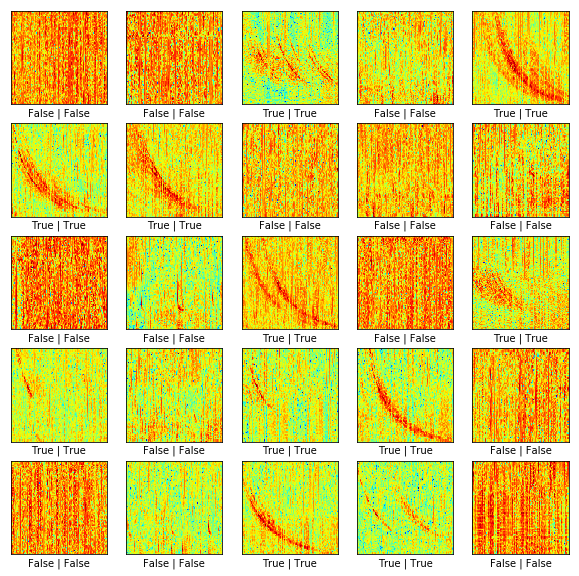

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k].reshape((parameters.clf_input_height,parameters.clf_input_width)), cmap='jet')
    plt.xlabel(str(pred[k].astype(np.bool_))+' | ' +str(evt[k].astype(np.bool_)))
plt.show()

In [ ]:
title= r"Loss Curves"
plt.figure()
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")

train_losses = np.array(train_losses)
cv_losses = np.array(cv_losses)

plt.grid()

# plt.fill_between(train_sizes,train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes,test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_losses, 'o-', color="r",
             label="Training loss")
plt.plot(cv_losses, 'o-', color="g",
             label="Cross-validation loss")
plt.legend(loc="best")
plt.show()